# Unsupervised Deep Learning Tutorial 1.1

In this part of the tutorial we will look at Long Short-Term Memory (LSTM) networks and how they work with time series.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random as rd
from typing import Tuple, Optional

torch.manual_seed(0)
rd.seed(0)

## Toy Time Series Data

Recurrent neural networks typically require a lot of data and time to train since temporal relationships are difficult to learn. Therefore, today we will train our models on extremely simple toy time series. The following function can be used to generate such datasets (feel free to change the parameters or try different time series):

In [2]:
def generate_toy_time_series(batch_size: int = 5, sequence_length: int = 100) -> Tuple[torch.Tensor, torch.Tensor]:

    t = torch.linspace(0, 1, sequence_length)

    # Create the sequences
    # Each one has a varying phase between 0 and 2pi
    # And a random frequency between 0 and 2pi
    # Feel free to play around with these parameters!
    sequences = []
    for sample in range(batch_size):
        phase = rd.random() * 2 * torch.pi
        frequency = rd.random() * 2 * torch.pi
        sequence = torch.sin(t * frequency + phase)
        sequences.append(sequence)

    # (batch_size, sequence_length) -> (batch_size, suquence_length, input_size)
    # Since each of our time series has a single feature, namely sin(t), out input_size is 1
    sequences = torch.stack(sequences).unsqueeze(-1)
    
    # Observations
    X = sequences[:, :-1]
    
    # Labels (observations shifted by one)
    y = sequences[:, 1:]
    
    return X, y

torch.Size([10, 99, 1]) torch.Size([10, 99, 1])


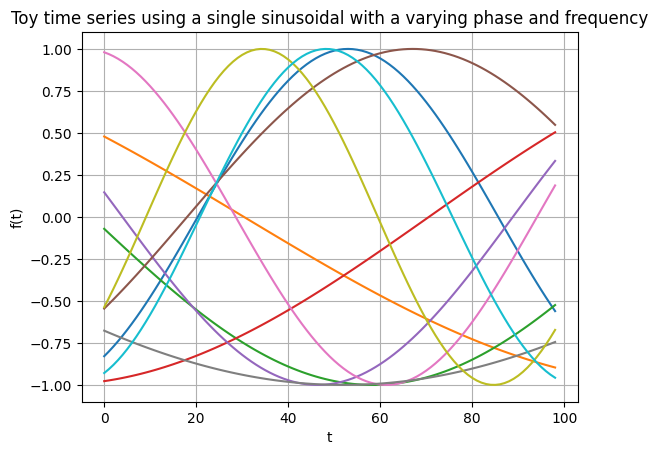

In [3]:
X, y = generate_toy_time_series(batch_size=10, sequence_length=100)
print(X.shape, y.shape)
for sample in X:
    plt.plot(sample.squeeze())
plt.xlabel('t')
plt.ylabel('f(t)')
plt.title('Toy time series using a single sinusoidal with a varying phase and frequency')
plt.grid()
plt.show()

The model will attempt to learn the batch of 10 time series wuth a sequence length of 99 and an input size of 1 presented above. It will be trained in an autoregressive self-supervised fashion, where the input is the function at time $t$ and the output is the estimated value of the function at time $t+1$. To be able to learn temporal information, the LSTM makes use of the hidden state $h_t$ and the cell state $c_t$ as presented in the lecture.

## The Long Short-Term Memory Layer

Formally, the forward pass of the LSTM is defined as follows:

\begin{align}
\tag{1a} & i_t = \sigma(x_tW^{(x,i)} + h_{t-1}W^{(h,i)} + b_i) \\
\tag{1b} & f_t = \sigma(x_tW^{(x,f)} + h_{t-1}W^{(h,f)} + b_f) \\
\tag{1c} & o_t = \sigma(x_tW^{(x,o)} + h_{t-1}W^{(h,o)} + b_o) \\
\tag{2} & c_t = \tanh(x_tW^{(x,c)} + h_{t-1}W^{(h,c)} + b_c) \\
\tag{3} & c_t \gets f_t\odot c_{t-1} + i_t \odot c_t \\
\tag{4} & h_t = o_t \odot \tanh(c_t)
\end{align}

- Input: $x_t\in\mathbb{R}^n$, the feature vector at time $t$, as well as the hidden and cell states $h_{t-1}\in\mathbb{R}^m, c_{t-1}\in\mathbb{R}^m$. Note that the states' dimensionality can differ from the input's (when $m\neq n$). At $t=0$, $h$ and $c$ are both 0. 
- Output: $h_t\in\mathbb{R}^m, c_t\in\mathbb{R}^m$, the hidden state and the cell state at the current time.
- The input (1a), forget (1b), and output (1c) gates are each associated with:
    1. Learnable weights $W^x\in\mathbb{R}^{n\times m}$
    2. Learnable weights $W^h\in\mathbb{R}^{m\times m}$
    3. Learnable bias $b\in\mathbb{R}^{m}$
    4. The sigmoid function $\sigma:\mathbb{R}\to\mathbb{R}$, which is applied element-wise
- $\odot:\mathbb{R}^k\times\mathbb{R}^k\to\mathbb{R}^k$ is the Hadamard product, i.e. pairwise multiplication of 2 $k$-dimensional vectors
- It is useful to add another learnable linear transformation add the end, $W^{\text{output}}\in\mathbb{R}^{m\times n}$, which would project the final output of the LSTM, namely $h_t$, back to the input space.

The implementation using PyTorch is quite straightforward. We can define each matrix and bias as a single linear layer

In [4]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size: int = 10, hidden_size: int = 50) -> None:
        super().__init__()
        
        self.input_size = input_size # n
        self.hidden_size = hidden_size # m
        
        # Input gate
        self.Wxi = nn.Linear(input_size, hidden_size)
        self.Whi = nn.Linear(hidden_size, hidden_size)

        # Forget gate
        self.Wxf = nn.Linear(input_size, hidden_size)
        self.Whf = nn.Linear(hidden_size, hidden_size)

        # Output gate
        self.Wxo = nn.Linear(input_size, hidden_size)
        self.Who = nn.Linear(hidden_size, hidden_size)

        # Memory proposal
        self.Wxc = nn.Linear(input_size, hidden_size)
        self.Whc = nn.Linear(hidden_size, hidden_size)
        
        # Final output
        self.Woutput = nn.Linear(hidden_size, input_size)

    def single_pass(self, x: torch.Tensor, h: Optional[torch.Tensor] = None, c: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:

        # x: (batch_size, input_size)
        # h: (batch_size, hidden_size)
        # c: (batch_size, hidden_size)
        
        # Happens in the first forward pass. Set h and c to 0
        if h is None: h = torch.zeros(len(x), self.hidden_size)
        if c is None: c = torch.zeros(len(x), self.hidden_size)

        # Gates: (batch_size, hidden_size)
        i = F.sigmoid(self.Wxi(x) + self.Whi(h))
        f = F.sigmoid(self.Wxf(x) + self.Whf(h))
        o = F.sigmoid(self.Wxo(x) + self.Who(h))

        # Update h and c: (batch_size, hidden_size)
        c_new = F.tanh(self.Wxc(x) + self.Whc(h))
        c_new = f * c + i * c_new
        h_new = o * F.tanh(c_new)
        
        return h_new, c_new
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # x: (batch_size, sequence_length, input_size)
        assert x.ndim == 3
        batch_size, sequence_length, input_size = x.shape
        h, c = None, None
        
        # Store all intermediate outputs
        outputs = []

        # Loop over the whole sequence.
        # Use the hidden states from the previous iteration
        # Store all hidden states, these are the outputs
        for t in range(sequence_length):
            h, c = self.single_pass(x[:, t], h, c)
            outputs.append(h)

        # (batch_size, sequence_length, hidden_size)
        H = torch.stack(outputs, dim=1)

        # Apply the final linear projection
        # (batch_size, sequence_length, hidden_size) -> (batch_size, sequence_length, input_size)
        return self.Woutput(H)


In [5]:
model = CustomLSTM(input_size=1, hidden_size=5)
print(model)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

CustomLSTM(
  (Wxi): Linear(in_features=1, out_features=5, bias=True)
  (Whi): Linear(in_features=5, out_features=5, bias=True)
  (Wxf): Linear(in_features=1, out_features=5, bias=True)
  (Whf): Linear(in_features=5, out_features=5, bias=True)
  (Wxo): Linear(in_features=1, out_features=5, bias=True)
  (Who): Linear(in_features=5, out_features=5, bias=True)
  (Wxc): Linear(in_features=1, out_features=5, bias=True)
  (Whc): Linear(in_features=5, out_features=5, bias=True)
  (Woutput): Linear(in_features=5, out_features=1, bias=True)
)
Number of parameters: 166


Amazing! Let's give it a shot:

In [6]:
test_output = model(X)
test_output.shape

torch.Size([10, 99, 1])

Everything appears to be working. Notice that the output of the LSTM is of the same shape as the input. This allows for stacking multiple LSTMs on top of eachother! Now for the training, we will use the Mean Squared Error loss to compare the predicted time series and the ground truth. Also, we will use the Adam optimizer. The task is really simple so the hyperparameters probably don't matter too much.

In [7]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

## Training

We are ready to train! This might take a while..

In [8]:
for i in range(1001):
    preds = model(X)
    loss = loss_fn(y, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%100 == 0: print(f'Epoch: {i} | Loss: {loss.item():.4f}')

Epoch: 0 | Loss: 0.7252
Epoch: 100 | Loss: 0.3546
Epoch: 200 | Loss: 0.1116
Epoch: 300 | Loss: 0.0541
Epoch: 400 | Loss: 0.0300
Epoch: 500 | Loss: 0.0185
Epoch: 600 | Loss: 0.0129
Epoch: 700 | Loss: 0.0098
Epoch: 800 | Loss: 0.0079
Epoch: 900 | Loss: 0.0064
Epoch: 1000 | Loss: 0.0052


Our model is learning! Now we can visualize its predictions on the training data. Note that the cell below only shows the 10 training samples. Feel free to change it.

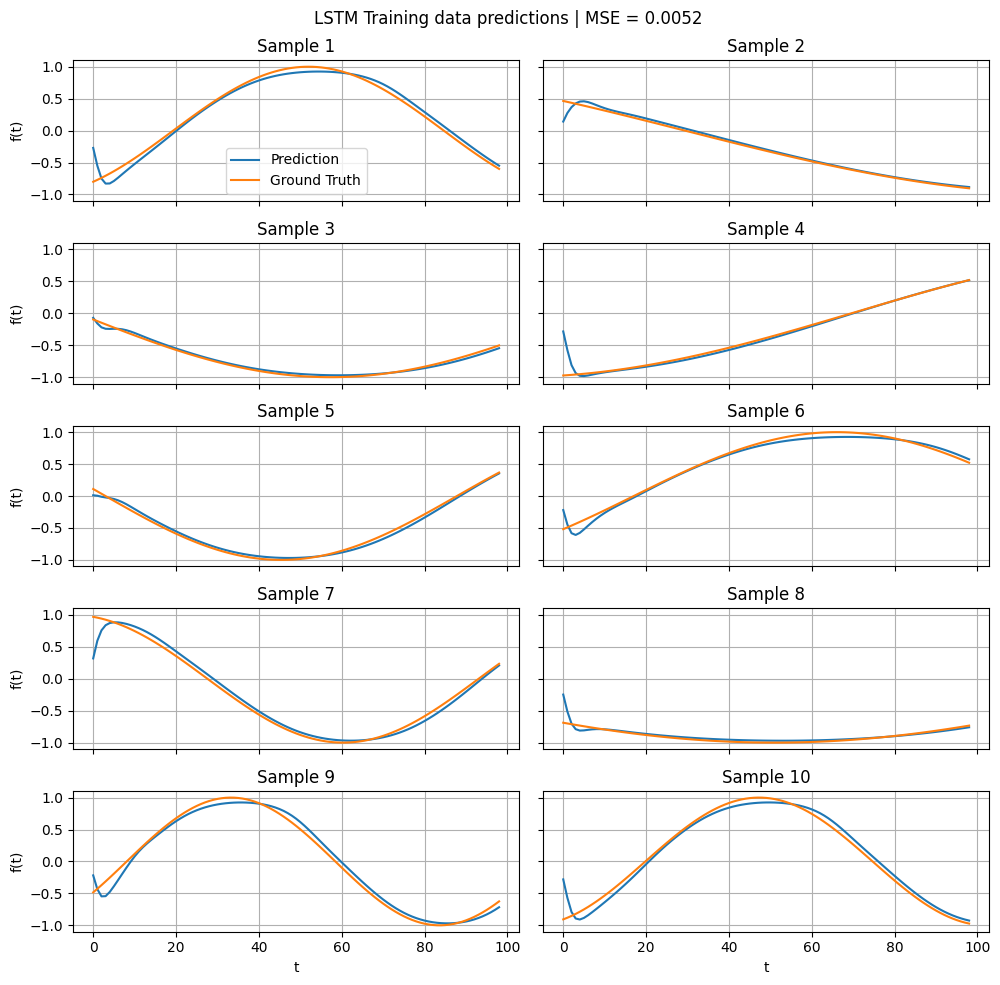

In [9]:
fig, ax = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(10, 10))
ax[-1][0].set_xlabel('t')
ax[-1][1].set_xlabel('t')
for a in ax[:, 0]:
    a.set_ylabel('f(t)')
ax = ax.flatten()
with torch.inference_mode():
    predictions = model(X)
for i, (sample, prediction, ground_truth, a) in enumerate(zip(X, predictions, y, ax)):
    a.plot(prediction.squeeze(), label='Prediction')
    a.plot(ground_truth.squeeze(), label='Ground Truth')
    a.grid()
    a.set_title(f'Sample {i+1}')
ax[0].legend()
plt.suptitle(f'LSTM Training data predictions | MSE = {loss.item():.4f}')
plt.tight_layout()
plt.show()

Wow! Our model is very good. Keep in mind that is a really simple solved with a really simple model. After all, we have only a single feature, which enables us to conveniently visualize the results. It still impressive that our model considers the last 100 timesteps before making a decision. That is like remembering what you ate for dinner the last 100 days in order to determine what to eat today. Long-term memory indeed. Note that the biggest mistakes of our model are at the very beginning of the time series, which is expected since there is no temporal information at that time. Although the same results can be achieved with a `nn.LSTM` from PyTorch, it is very useful to understand the models at a low level. An amazing source for LSTMs is [StatQuest on YouTube](https://youtu.be/YCzL96nL7j0?si=rsGGt9KwoYg6OXG0)!

## Evaluation

We can test how our model performs on unseen data. Let's generate another random time series and have our model predict it:

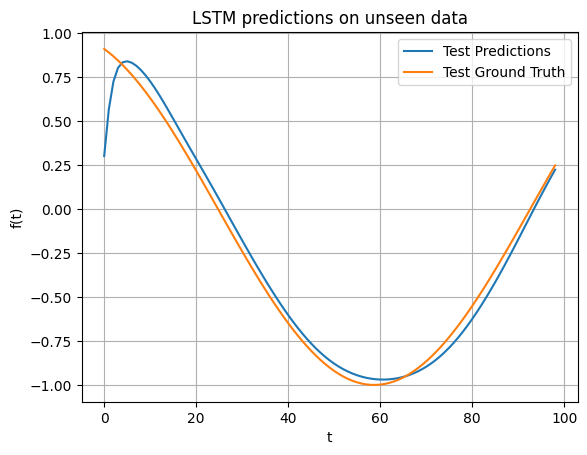

In [10]:
X_test, y_test = generate_toy_time_series(batch_size=1, sequence_length=100)
with torch.inference_mode():
    test_predictions = model(X_test)
plt.plot(test_predictions.squeeze(), label='Test Predictions')
plt.plot(y_test.squeeze(), label='Test Ground Truth')
plt.title('LSTM predictions on unseen data')
plt.legend()
plt.xlabel('t')
plt.ylabel('f(t)')
plt.grid()
plt.show()

It is a really good match!

## Your Task

Hopefully everything has been clear so far! You might have noticed that our model is a bit boring as we have trained it to predict only the next time step $t+1$ given the current time step $t$. In practice, we would like something that predicts further into the future. Write a script that uses the model we just trained and the testing example to predict the time series up to $n$ steps into the future with, e.g., $n=10$. Does the model perform as expected? Can we reliably use it for forecasting? Visualize the results.

In [ ]:
# Your code here